# Reconnaissance Faciale CNN - big_dataset_lfw

- **Dataset**: Images morphées (identités multiples)
- **Architecture**: CNN optimisée
- **Split**: 80% train, 20% test

In [25]:
# Imports
import numpy as np
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(f"Keras version: {keras.__version__}")

Keras version: 3.13.2


In [26]:
# ============================================================
# CONFIGURATION
# ============================================================

DATA_PATH = Path("big_dataset_lfw")  # ou ton chemin absolu

IM_ROWS = 112
IM_COLS = 92
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

IMAGE_EXTENSIONS = {'.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif'}

In [27]:
# ============================================================
# CHARGEMENT DES IMAGES DEPUIS LES SOUS-DOSSIERS
# ============================================================

print("Chargement des images...")

DATA_PATH = Path(DATA_PATH)

# Trouver tous les sous-dossiers (= identités)
subdirs = sorted([d for d in DATA_PATH.iterdir() if d.is_dir()])

# Créer le mapping identité -> label
identities = [d.name for d in subdirs]
identity_to_label = {name: idx for idx, name in enumerate(identities)}
num_classes = len(identities)

print(f"Nombre de classes: {num_classes}")
print(f"Identités: {identities}")

X = []
y = []

# Parcourir chaque sous-dossier
for subdir in subdirs:
    identity = subdir.name
    label = identity_to_label[identity]
    
    # Lister toutes les images du sous-dossier
    image_files = [f for f in subdir.iterdir() if f.suffix.lower() in IMAGE_EXTENSIONS]
    
    for filepath in image_files:
        img = cv2.imread(str(filepath), cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            img = cv2.resize(img, (IM_COLS, IM_ROWS))
            X.append(img)
            y.append(label)
    
    print(f"  ✓ {identity}: {len(image_files)} images")

# Convertir en arrays numpy
X = np.array(X, dtype='float32') / 255.0
y = np.array(y, dtype='int32')

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

# Stats par classe
for name, label in identity_to_label.items():
    count = np.sum(y == label)
    print(f"  Classe {label} ({name}): {count} images")

Chargement des images...
Nombre de classes: 5
Identités: ['01_02', '03_04', '05_06', '07_08', '09_10']
  ✓ 01_02: 400 images
  ✓ 03_04: 400 images
  ✓ 05_06: 400 images
  ✓ 07_08: 400 images
  ✓ 09_10: 400 images

X shape: (2000, 112, 92)
y shape: (2000,)
  Classe 0 (01_02): 400 images
  Classe 1 (03_04): 400 images
  Classe 2 (05_06): 400 images
  Classe 3 (07_08): 400 images
  Classe 4 (09_10): 400 images


In [28]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)

# Reshape pour CNN
X_train = X_train.reshape(-1, IM_ROWS, IM_COLS, 1)
X_valid = X_valid.reshape(-1, IM_ROWS, IM_COLS, 1)
X_test = X_test.reshape(-1, IM_ROWS, IM_COLS, 1)

print(f"Train: {X_train.shape[0]} images")
print(f"Valid: {X_valid.shape[0]} images")
print(f"Test: {X_test.shape[0]} images")

Train: 1440 images
Valid: 160 images
Test: 400 images


In [32]:
# ============================================================
# EXTRACTION DES IDENTITÉS
# ============================================================

def get_identity(filename):
    """
    Extrait l'identité du nom de fichier.
    Adapte cette fonction selon ton format de nommage!
    
    Exemples de formats supportés:
    - morph_lfw_XX_YY__img_001.png -> morph_lfw_XX_YY
    - person01_001.png -> person01
    - identity_0_image_123.png -> identity_0
    """
    name = filename.stem if isinstance(filename, Path) else filename.replace('.png', '').replace('.jpg', '')
    
    # Format: morph_lfw_XX_YY__img_...
    if name.startswith('morph_lfw_'):
        parts = name.split('_')
        return '_'.join(parts[:4])  # morph_lfw_XX_YY
    
    # Format: identityXX_imageYY ou personXX_YY
    elif '_' in name:
        parts = name.split('_')
        # Prendre tout sauf le dernier élément (numéro d'image)
        return '_'.join(parts[:-1])
    
    # Format par défaut: premiers caractères avant les chiffres
    else:
        import re
        match = re.match(r'^([a-zA-Z_]+)', name)
        return match.group(1) if match else name[:10]

# Tester l'extraction d'identités
if all_files:
    print("Test d'extraction d'identités:")
    for f in all_files[:5]:
        print(f"  {f.name} -> {get_identity(f)}")
    
    # Extraire toutes les identités uniques
    identities = sorted(list(set([get_identity(f) for f in all_files])))
    identity_to_label = {name: idx for idx, name in enumerate(identities)}
    num_classes = len(identities)
    
    print(f"\nIdentités trouvées ({num_classes}):")
    for name in identities:
        count = sum(1 for f in all_files if get_identity(f) == name)
        print(f"  - {name}: {count} images")

In [47]:
# ============================================================
# ARCHITECTURE CNN AVEC FORTE RÉGULARISATION
# ============================================================

from keras.layers import GlobalAveragePooling2D
from keras.regularizers import l2

model = Sequential([
    # Block 1 - moins de filtres
    Conv2D(16, kernel_size=3, activation='relu', padding='same', 
           kernel_regularizer=l2(0.01),
           input_shape=(IM_ROWS, IM_COLS, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.3),
    
    # Block 2
    Conv2D(32, kernel_size=3, activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.3),
    
    # Block 3
    Conv2D(64, kernel_size=3, activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.4),
    
    # Global Average Pooling au lieu de Flatten (moins de paramètres)
    GlobalAveragePooling2D(),
    
    # Une seule couche dense
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),  # Learning rate plus élevé
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 112, 92, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 92, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 56, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 46, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,229 (110.27 KB)

 Trainable params: 28,005 (109.39 KB)

 Non-trainable params: 224 (896.00 B)

In [49]:
# ============================================================
# DATA AUGMENTATION (Keras 3 compatible)
# ============================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [36]:
# ============================================================
# CALLBACKS POUR L'ENTRAÎNEMENT
# ============================================================

callbacks = [
    # Arrêt anticipé si pas d'amélioration
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    # Réduction du learning rate si plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configurés:")
print("  - EarlyStopping (patience=20)")
print("  - ReduceLROnPlateau (factor=0.5, patience=10)")

Callbacks configurés:
  - EarlyStopping (patience=20)
  - ReduceLROnPlateau (factor=0.5, patience=10)


In [50]:
# ============================================================
# ENTRAÎNEMENT AVEC DATA AUGMENTATION
# ============================================================

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # Surveiller accuracy, pas loss
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        mode='max',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Batch plus petit
    epochs=200,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accuracy: 0.1896 - loss: 2.9412 - val_accuracy: 0.2000 - val_loss: 2.6661 - learning_rate: 0.0010
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.2236 - loss: 2.5662 - val_accuracy: 0.2000 - val_loss: 2.4900 - learning_rate: 0.0010
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.2465 - loss: 2.3901 - val_accuracy: 0.2000 - val_loss: 2.3537 - learning_rate: 0.0010
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.2694 - loss: 2.2405 - val_accuracy: 0.2000 - val_loss: 2.2943 - learning_rate: 0.0010
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.2729 - loss: 2.1299 - val_accuracy: 0.2000 - val_loss: 2.2493 - learning_rate: 0.0010
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.3014 - loss: 2.0080 - val_accuracy: 0.2000 - val_loss: 2.1295 - learning_rate: 0.0010
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.3389 - loss: 1

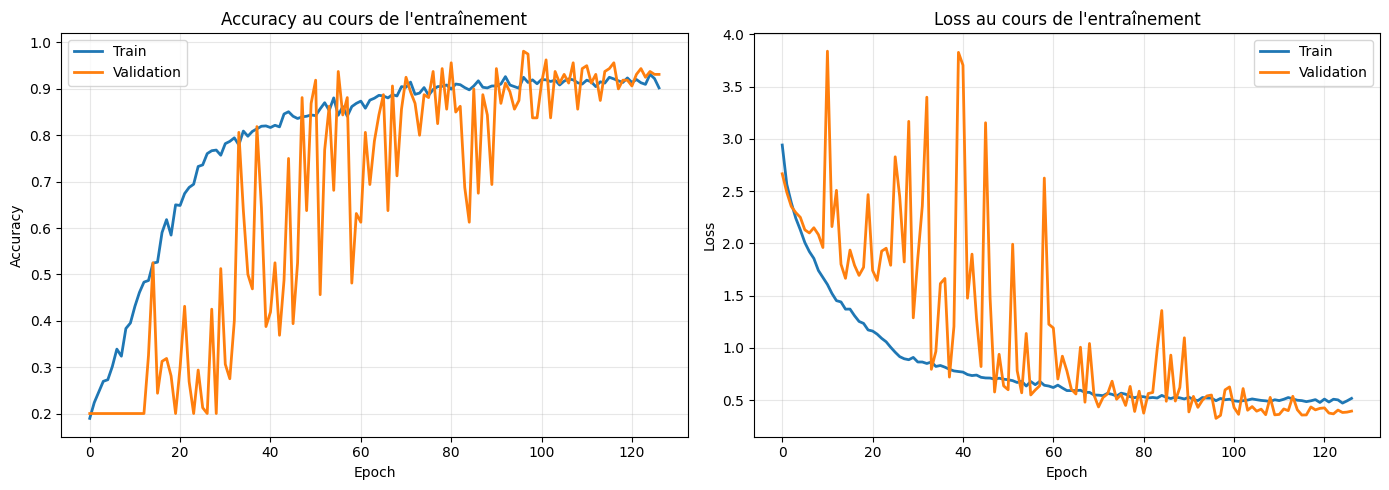


Meilleure epoch: 97
  - Val Accuracy: 98.12%
  - Val Loss: 0.3252


In [51]:
# ============================================================
# COURBES D'ENTRAÎNEMENT
# ============================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Accuracy au cours de l\'entraînement', fontsize=12)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Loss au cours de l\'entraînement', fontsize=12)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Afficher les meilleures métriques
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nMeilleure epoch: {best_epoch + 1}")
print(f"  - Val Accuracy: {history.history['val_accuracy'][best_epoch]*100:.2f}%")
print(f"  - Val Loss: {history.history['val_loss'][best_epoch]:.4f}")

In [52]:
# ============================================================
# ÉVALUATION SUR LE TEST SET
# ============================================================

# Évaluation globale
score = model.evaluate(X_test, y_test, verbose=0)
print("=" * 60)
print("RÉSULTATS SUR LE TEST SET")
print("=" * 60)
print(f"Test Loss: {score[0]:.4f}")
print(f"Test Accuracy: {score[1]*100:.2f}%")

# Prédictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Rapport de classification
print("\n" + "=" * 60)
print("RAPPORT DE CLASSIFICATION")
print("=" * 60)

# Utiliser les noms d'identités comme labels
target_names = [identities[i] for i in range(num_classes)]
# Raccourcir si trop long
target_names = [n[:15] if len(n) > 15 else n for n in target_names]

print(classification_report(y_test, y_pred, target_names=target_names))

RÉSULTATS SUR LE TEST SET
Test Loss: 0.3086
Test Accuracy: 98.00%

RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

       01_02       1.00      0.96      0.98        80
       03_04       1.00      1.00      1.00        80
       05_06       1.00      0.96      0.98        80
       07_08       0.98      1.00      0.99        80
       09_10       0.93      0.97      0.95        80

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



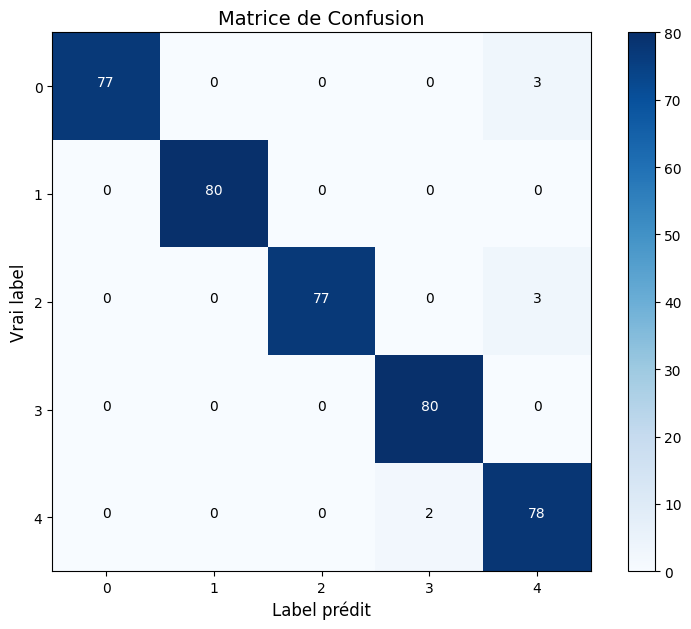


Accuracy par classe:
  Classe 0 (01_02): 96.2%
  Classe 1 (03_04): 100.0%
  Classe 2 (05_06): 96.2%
  Classe 3 (07_08): 100.0%
  Classe 4 (09_10): 97.5%


In [53]:
# ============================================================
# MATRICE DE CONFUSION
# ============================================================

cm = confusion_matrix(y_test, y_pred)

# Taille de figure adaptée au nombre de classes
fig_size = max(8, num_classes * 1.5)
plt.figure(figsize=(fig_size, fig_size * 0.8))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de Confusion', fontsize=14)
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))

# Ajouter les valeurs dans les cellules
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=10)

plt.ylabel('Vrai label', fontsize=12)
plt.xlabel('Label prédit', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Accuracy par classe
print("\nAccuracy par classe:")
for i in range(num_classes):
    class_acc = cm[i, i] / cm[i, :].sum() * 100 if cm[i, :].sum() > 0 else 0
    print(f"  Classe {i} ({identities[i]}): {class_acc:.1f}%")

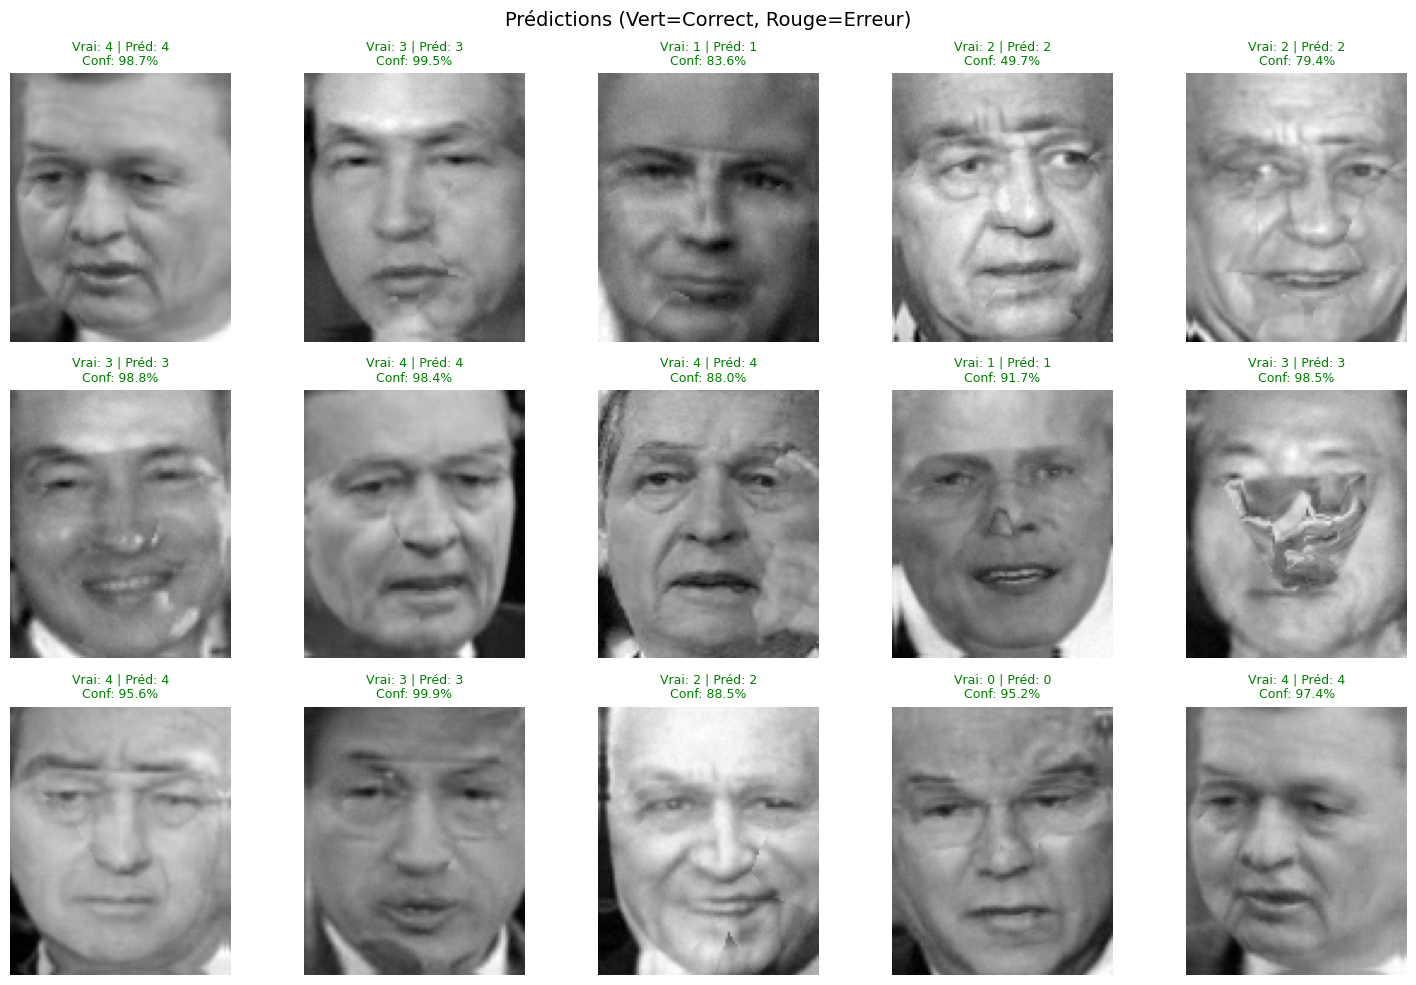

In [54]:
# ============================================================
# VISUALISATION DES PRÉDICTIONS
# ============================================================

n_samples = 15
indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(indices):
    axes[i].imshow(X_test[idx].reshape(IM_ROWS, IM_COLS), cmap='gray')
    
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    confidence = y_pred_proba[idx, pred_label] * 100
    
    is_correct = true_label == pred_label
    color = 'green' if is_correct else 'red'
    
    axes[i].set_title(
        f"Vrai: {true_label} | Préd: {pred_label}\nConf: {confidence:.1f}%", 
        color=color,
        fontsize=9
    )
    axes[i].axis('off')

plt.suptitle('Prédictions (Vert=Correct, Rouge=Erreur)', fontsize=14)
plt.tight_layout()
plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
plt.show()

Nombre d'erreurs: 8 / 400 (2.0%)


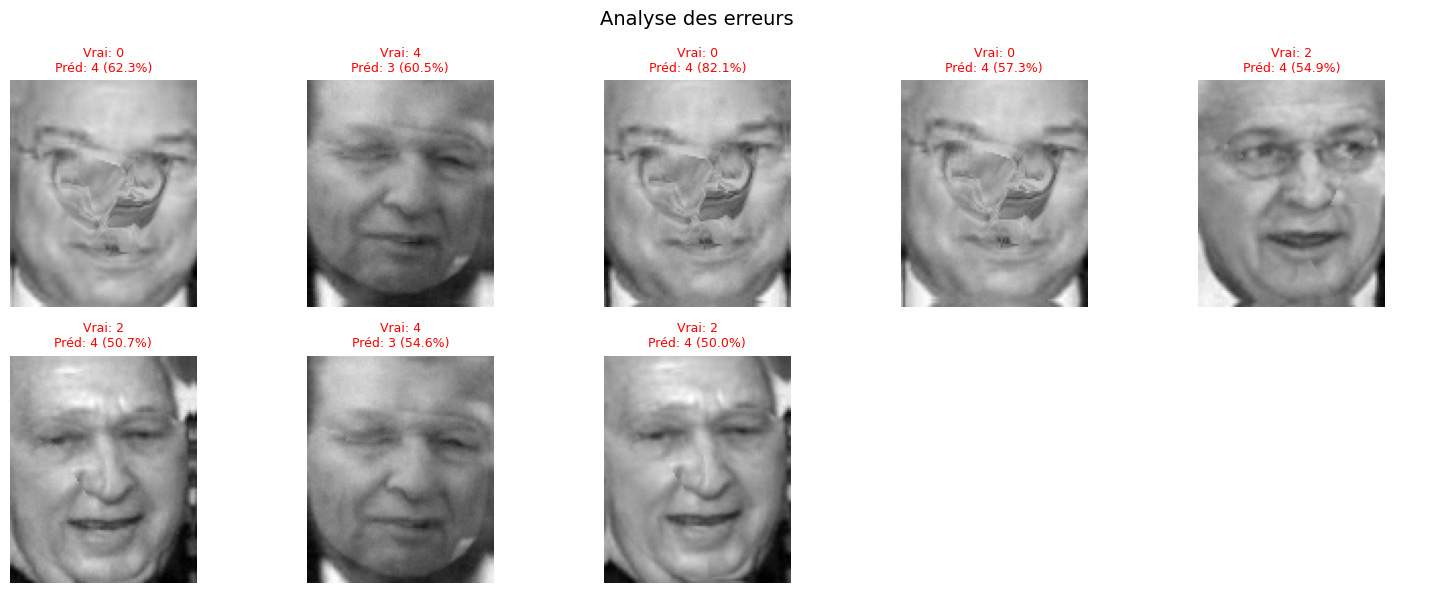

In [55]:
# ============================================================
# ANALYSE DES ERREURS
# ============================================================

# Trouver les erreurs
errors_idx = np.where(y_test != y_pred)[0]
print(f"Nombre d'erreurs: {len(errors_idx)} / {len(y_test)} ({len(errors_idx)/len(y_test)*100:.1f}%)")

if len(errors_idx) > 0:
    # Visualiser quelques erreurs
    n_errors = min(10, len(errors_idx))
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, idx in enumerate(errors_idx[:n_errors]):
        axes[i].imshow(X_test[idx].reshape(IM_ROWS, IM_COLS), cmap='gray')
        
        true_label = y_test[idx]
        pred_label = y_pred[idx]
        confidence = y_pred_proba[idx, pred_label] * 100
        
        axes[i].set_title(
            f"Vrai: {true_label}\nPréd: {pred_label} ({confidence:.1f}%)", 
            color='red',
            fontsize=9
        )
        axes[i].axis('off')
    
    # Cacher les axes vides
    for i in range(n_errors, 10):
        axes[i].axis('off')
    
    plt.suptitle('Analyse des erreurs', fontsize=14)
    plt.tight_layout()
    plt.savefig('error_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

In [43]:
# ============================================================
# SAUVEGARDE DU MODÈLE
# ============================================================

# Sauvegarder au format Keras
model.save('cnn_face_recognition.keras')
print("✅ Modèle sauvegardé: cnn_face_recognition.keras")

# Sauvegarder aussi les métadonnées
import json

metadata = {
    'identities': identities,
    'identity_to_label': identity_to_label,
    'num_classes': num_classes,
    'image_size': (IM_ROWS, IM_COLS),
    'test_accuracy': float(score[1]),
    'test_loss': float(score[0])
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
    
print("✅ Métadonnées sauvegardées: model_metadata.json")

✅ Modèle sauvegardé: cnn_face_recognition.keras
✅ Métadonnées sauvegardées: model_metadata.json


In [57]:
# ============================================================
# RÉSUMÉ FINAL
# ============================================================

print("=" * 60)
print("RÉSUMÉ DE L'ENTRAÎNEMENT")
print("=" * 60)
print(f"Dataset: {DATA_PATH}")
total_images = len(X_train) + len(X_valid) + len(X_test)
print(f"Images totales: {total_images} ({num_classes} classes)")
print(f"Train/Valid/Test: {len(X_train)}/{len(X_valid)}/{len(X_test)}")
print(f"Taille des images: {IM_ROWS}x{IM_COLS}")
print("-" * 60)
print(f"Epochs entraînés: {len(history.history['loss'])}")
print(f"Meilleure val accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print("-" * 60)
print(f"Test Accuracy: {score[1]*100:.2f}%")
print(f"Test Loss: {score[0]:.4f}")
print("=" * 60)
print("\nFichiers générés:")
print("  - cnn_face_recognition.keras")
print("  - model_metadata.json")
print("  - training_curves.png")
print("  - confusion_matrix.png")
print("  - predictions.png")
print("  - error_analysis.png")

RÉSUMÉ DE L'ENTRAÎNEMENT
Dataset: big_dataset_lfw
Images totales: 2000 (5 classes)
Train/Valid/Test: 1440/160/400
Taille des images: 112x92
------------------------------------------------------------
Epochs entraînés: 127
Meilleure val accuracy: 98.12%
------------------------------------------------------------
Test Accuracy: 98.00%
Test Loss: 0.3086

Fichiers générés:
  - cnn_face_recognition.keras
  - model_metadata.json
  - training_curves.png
  - confusion_matrix.png
  - predictions.png
  - error_analysis.png
